In [ ]:
import torch

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def space_to_channel(x, scale):
  """
  Space-to-channel operation (non-parametric shortcut for downsample block).

  Args:
    x: Input tensor of shape (B, C, H, W).
    scale: Downsampling scale.

  Returns:
    Output tensor of shape (B, C * scale, H / scale, W / scale).
  """
  B, C, H, W = x.size()
  return x.view(B, C, H // scale, scale, W // scale, scale).permute(0, 1, 3, 5, 2, 4).reshape(B, C * scale, scale, H // scale, W // scale).mean(dim=2)

def channel_to_space(x, scale):
  """
  Channel-to-space operation (non-parametric shortcut for upsample block).

  Args:
    x: Input tensor of shape (B, C * scale, H / scale, W / scale).
    scale: Upsampling scale.

  Returns:
    Output tensor of shape (B, C, H, W).
  """
  B, C, H, W = x.size()
  x =  x.view(B, C // (scale * scale), scale, scale, H, W).permute(0, 1, 4, 2, 5, 3).reshape(B, C // (scale * scale), H * scale, W * scale)
  return torch.cat((x, x), dim=1)

class ResidualBlock(nn.Module):
  """
  Residual block used in both encoder and decoder.
  """
  def __init__(self, in_channels, out_channels, is_middle=False):
    super().__init__()
    self.is_middle = is_middle
    # Calculate num_groups based on in_channels to ensure divisibility
    num_groups = min(32, in_channels)
    self.conv1 = nn.Sequential(
        nn.GroupNorm(num_groups, in_channels), # Use calculated num_groups
        nn.SiLU(),
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.Dropout(0.01)
    )
    # Calculate num_groups based on out_channels to ensure divisibility
    num_groups = min(32, out_channels)
    self.conv2 = nn.Sequential(
        nn.GroupNorm(num_groups, out_channels), # Use calculated num_groups
        nn.SiLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.Dropout(0.01)
    )
    if is_middle:
        self.conv_shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    self.initialize_weights()

  def initialize_weights(self):
    # Initialize conv layers with kaiming_normal
    for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.GroupNorm):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
    # Zero-initialize the last conv layer in each residual block
    nn.init.constant_(self.conv2[-2].weight, 0)
    if self.is_middle:
        nn.init.constant_(self.conv_shortcut.weight, 0)

  def forward(self, x):
    identity = x
    x = self.conv1(x)
    x = self.conv2(x)
    if self.is_middle:
      identity = self.conv_shortcut(identity)
      x = x + identity
    return x

class DownsampleResidualBlock(nn.Module):
  """
  Residual block used in both encoder and decoder.
  """
  def __init__(self, in_channels, out_channels, is_middle=False):
    super().__init__()
    self.is_middle = is_middle
    # Calculate num_groups based on in_channels to ensure divisibility
    num_groups = min(32, in_channels)
    self.conv1 = nn.Sequential(
        nn.GroupNorm(num_groups, in_channels), # Use calculated num_groups
        nn.SiLU(),
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2),
        nn.Dropout(0.01)
    )
    # Calculate num_groups based on out_channels to ensure divisibility
    num_groups = min(32, out_channels)
    self.conv2 = nn.Sequential(
        nn.GroupNorm(num_groups, out_channels), # Use calculated num_groups
        nn.SiLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=2),
        nn.Dropout(0.01)
    )
    if is_middle:
        self.conv_shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    self.initialize_weights()

  def initialize_weights(self):
    # Initialize conv layers with kaiming_normal
    for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.GroupNorm):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
    # Zero-initialize the last conv layer in each residual block
    nn.init.constant_(self.conv2[-2].weight, 0)
    if self.is_middle:
        nn.init.constant_(self.conv_shortcut.weight, 0)

  def forward(self, x):
    identity = x
    x = self.conv1(x)
    x = self.conv2(x)
    if self.is_middle:
      identity = self.conv_shortcut(identity)
      x = x + identity
    return x

class UpsampleResidualBlock(nn.Module):
  """
  Residual block used in both encoder and decoder.
  """
  def __init__(self, in_channels, out_channels, is_middle=False):
    super().__init__()
    self.is_middle = is_middle
    # Calculate num_groups based on in_channels to ensure divisibility
    num_groups = min(32, in_channels)
    self.conv1 = nn.Sequential(
        nn.GroupNorm(num_groups, in_channels), # Use calculated num_groups
        nn.SiLU(),
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, padding=0, stride=2),
        nn.Dropout(0.01)
    )
    # Calculate num_groups based on out_channels to ensure divisibility
    num_groups = min(32, out_channels)
    self.conv2 = nn.Sequential(
        nn.GroupNorm(num_groups, out_channels), # Use calculated num_groups
        nn.SiLU(),
        nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, padding=0, stride=2),
        nn.Dropout(0.01)
    )
    if is_middle:
        self.conv_shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    self.initialize_weights()

  def initialize_weights(self):
    # Initialize conv layers with kaiming_normal
    for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.GroupNorm):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
    # Zero-initialize the last conv layer in each residual block
    nn.init.constant_(self.conv2[-2].weight, 0)
    if self.is_middle:
        nn.init.constant_(self.conv_shortcut.weight, 0)

  def forward(self, x):
    identity = x
    x = self.conv1(x)
    x = self.conv2(x)
    if self.is_middle:
      identity = self.conv_shortcut(identity)
      x = x + identity
    return x

class DownsampleBlock(nn.Module):
  """
  Downsample block with residual autoencoding.
  """
  def __init__(self, in_channels, out_channels, scale=2):
    super().__init__()
    self.residual_block = DownsampleResidualBlock(in_channels, out_channels)
    self.scale = scale
    self.channel_avg = nn.AvgPool2d(kernel_size=scale)
    self.initialize_weights()

  def initialize_weights(self):
        # Zero-initialize the channel_avg layer
        if isinstance(self.channel_avg, nn.AvgPool2d):
            for m in self.channel_avg.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.constant_(m.weight, 0)
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)

  def forward(self, x):
    shortcut = space_to_channel(x, self.scale)
    shortcut = self.channel_avg(shortcut)
    x = self.residual_block(x)
    return x + shortcut

class UpsampleBlock(nn.Module):
  """
  Upsample block with residual autoencoding.
  """
  def __init__(self, in_channels, out_channels, scale=2):
    super().__init__()
    self.residual_block = UpsampleResidualBlock(in_channels, out_channels)
    self.scale = scale
    self.channel_dup = nn.Upsample(scale_factor=scale, mode='nearest')

  def forward(self, x):
    shortcut = channel_to_space(x, self.scale)
    shortcut = self.channel_dup(shortcut)
    x = self.residual_block(x)
    return x + shortcut

class Encoder(nn.Module):
  def __init__(self, in_channels=3, latent_channels=16, channels=[16, 32], scales=[2, 2]):
    super().__init__()
    self.init_conv = nn.Conv2d(in_channels, channels[0], kernel_size=3, padding=1)
    self.downsample_blocks = nn.ModuleList([
        DownsampleBlock(channels[i], channels[i+1], scale=scales[i]) for i in range(len(channels)-1)
    ])
    self.middle_stage = nn.Sequential(
        ResidualBlock(channels[-1], channels[-1], is_middle=True),
        ResidualBlock(channels[-1], latent_channels, is_middle=True),
    )
    self.middle_shortcut = nn.Sequential(
        nn.GroupNorm(32, channels[-1]),
        nn.SiLU(),
        nn.Conv2d(channels[-1], latent_channels, kernel_size=3, padding=1),
        nn.Dropout(0.05)
    )
    self.initialize_weights()

  def initialize_weights(self):
    # Initialize init_conv layer with kaiming_normal
    nn.init.kaiming_normal_(self.init_conv.weight, mode='fan_out', nonlinearity='relu')
    if self.init_conv.bias is not None:
        nn.init.constant_(self.init_conv.bias, 0)

    # Initialize middle_shortcut layers with kaiming_normal
    for m in self.middle_shortcut.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.GroupNorm):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

  def forward(self, x):
    x = self.init_conv(x)
    for block in self.downsample_blocks:
      x = block(x)
    middle = self.middle_stage(x)
    middle_shortcut = self.middle_shortcut(x)
    x = middle + middle_shortcut
    return x

class Decoder(nn.Module):
  def __init__(self, out_channels=3, latent_channels=16, channels=[32, 16], scales=[2, 2]):
    super().__init__()
    self.middle_stage = nn.Sequential(
        ResidualBlock(latent_channels, channels[0], is_middle=True),
        ResidualBlock(channels[0], channels[0], is_middle=True),
    )
    num_groups = min(32, latent_channels)
    self.middle_shortcut = nn.Sequential(
        nn.GroupNorm(num_groups, latent_channels),
        nn.SiLU(),
        nn.Conv2d(latent_channels, channels[0], kernel_size=3, padding=1),
        nn.Dropout(0.01)
    )
    self.upsample_blocks = nn.ModuleList([
        UpsampleBlock(channels[i], channels[i+1], scale=scales[i]) for i in range(len(channels)-1)
    ])
    self.final_conv = nn.Sequential(
        nn.GroupNorm(8, channels[-1]),
        nn.SiLU(),
        nn.Conv2d(channels[-1], out_channels, kernel_size=3, padding=1),
    )
    self.initialize_weights()

  def initialize_weights(self):
        # Initialize final_conv layers with kaiming_normal
        for m in self.final_conv.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.GroupNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

  def forward(self, x):
    middle = self.middle_stage(x)
    middle_shortcut = self.middle_shortcut(x)
    x = middle + middle_shortcut
    for block in self.upsample_blocks:
      x = block(x)
    x = self.final_conv(x)
    return x

class DCAE(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, latent_channels=16, encoder_channels=[16, 32, 64], decoder_channels=[64, 32, 16], scales=[2, 2, 2]):
        super().__init__()
        self.encoder = Encoder(in_channels, latent_channels, encoder_channels, scales)
        self.decoder = Decoder(out_channels, latent_channels, decoder_channels, scales)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# Example usage:
model = DCAE(
    in_channels=3,
    out_channels=3,
    latent_channels=16,
    encoder_channels=[16, 32],  # Reduced channels
    decoder_channels=[32, 16],  # Reduced channels
    scales=[2, 2]  # f8 compression: 32 / (2*2*2) = 4
)

model.to(device)

DCAE(
  (encoder): Encoder(
    (init_conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample_blocks): ModuleList(
      (0): DownsampleBlock(
        (residual_block): DownsampleResidualBlock(
          (conv1): Sequential(
            (0): GroupNorm(16, 16, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (3): Dropout(p=0.01, inplace=False)
          )
          (conv2): Sequential(
            (0): GroupNorm(32, 32, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (3): Dropout(p=0.01, inplace=False)
          )
        )
        (channel_avg): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
    )
    (middle_stage): Sequential(
      (0): ResidualBlock(
        (conv1): Sequential(
          (0): GroupNorm(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
 

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1]
    # If you want to use Phase 3 (GAN), consider normalizing to [-1, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 Dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=.01)
criterion = nn.L1Loss()  # Or L1Loss, or LPIPS if you have it implemented

In [ ]:
# Training Loop (Phase 1)
num_epochs = 40
for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = criterion(recon_batch, data)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}')

Epoch: 1/40, Batch: 1/98, Loss: 1.4840
Epoch: 1/40, Batch: 11/98, Loss: 0.9414
Epoch: 1/40, Batch: 21/98, Loss: 0.6750
Epoch: 1/40, Batch: 31/98, Loss: 0.5410
Epoch: 1/40, Batch: 41/98, Loss: 0.4818
Epoch: 1/40, Batch: 51/98, Loss: 0.4397
Epoch: 1/40, Batch: 61/98, Loss: 0.4094
Epoch: 1/40, Batch: 71/98, Loss: 0.3963
Epoch: 1/40, Batch: 81/98, Loss: 0.3832
Epoch: 1/40, Batch: 91/98, Loss: 0.3717
Epoch: 2/40, Batch: 1/98, Loss: 0.3678
Epoch: 2/40, Batch: 11/98, Loss: 0.3560
Epoch: 2/40, Batch: 21/98, Loss: 0.3434
Epoch: 2/40, Batch: 31/98, Loss: 0.3367
Epoch: 2/40, Batch: 41/98, Loss: 0.3311
Epoch: 2/40, Batch: 51/98, Loss: 0.3232
Epoch: 2/40, Batch: 61/98, Loss: 0.3122
Epoch: 2/40, Batch: 71/98, Loss: 0.3140
Epoch: 2/40, Batch: 81/98, Loss: 0.3126
Epoch: 2/40, Batch: 91/98, Loss: 0.2942
Epoch: 3/40, Batch: 1/98, Loss: 0.3019
Epoch: 3/40, Batch: 11/98, Loss: 0.2957
Epoch: 3/40, Batch: 21/98, Loss: 0.2889
Epoch: 3/40, Batch: 31/98, Loss: 0.2875
Epoch: 3/40, Batch: 41/98, Loss: 0.2795
Epo

Files already downloaded and verified


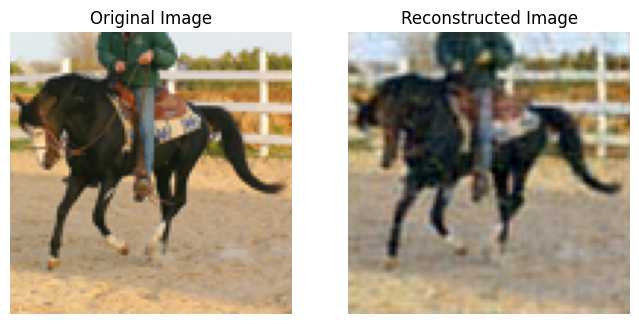

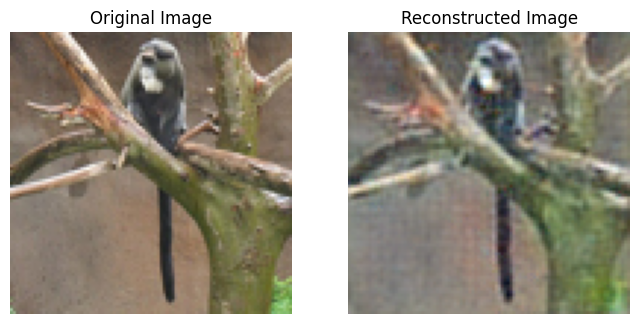

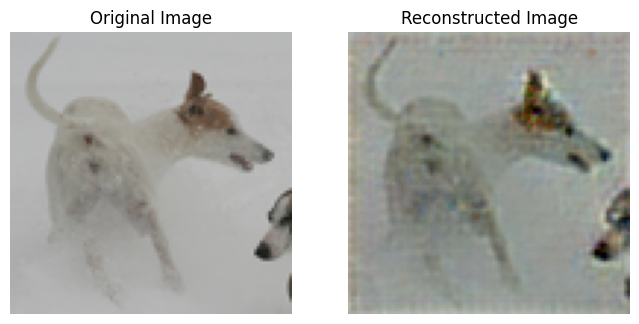

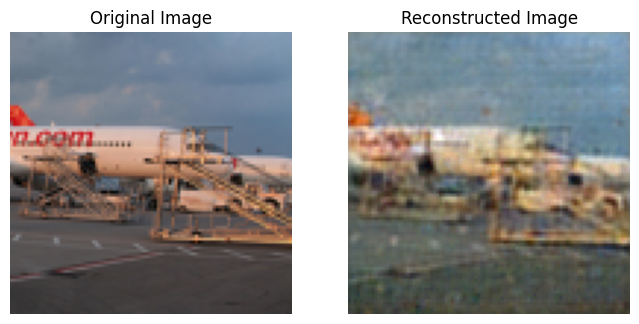

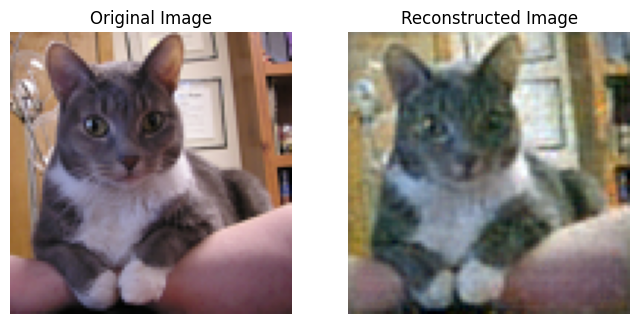

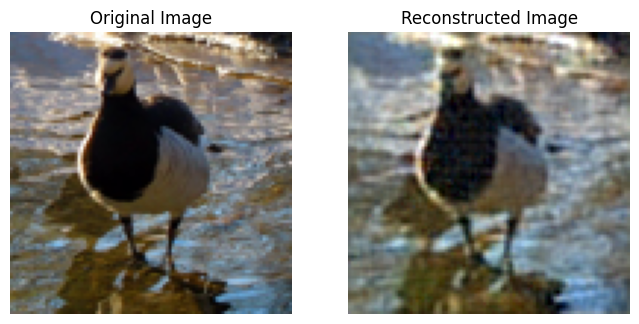

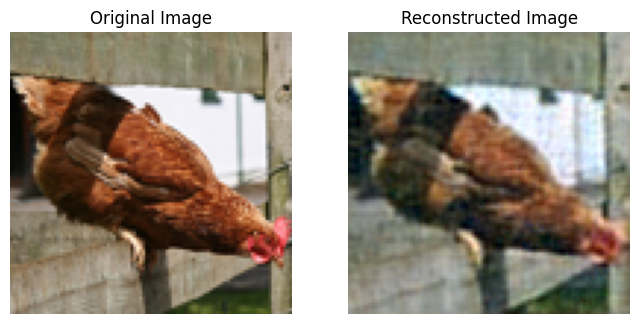

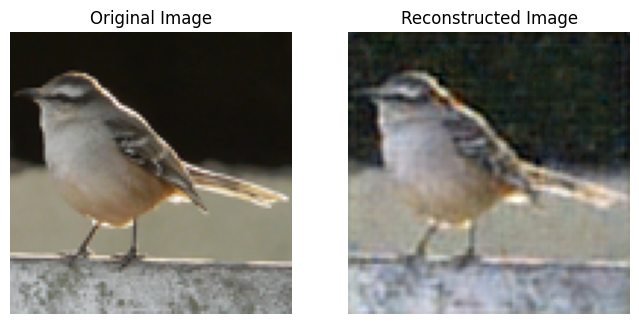

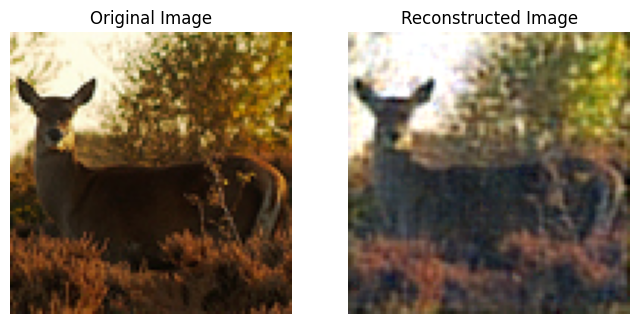

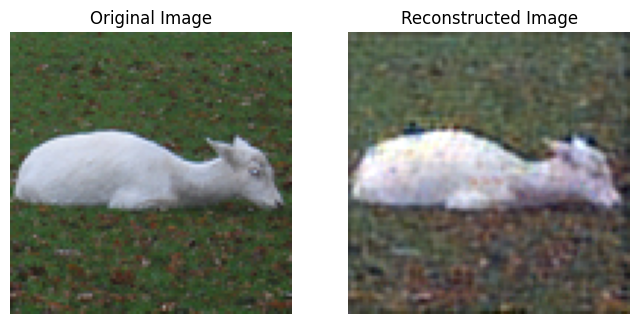

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- STL-10 Test Dataset ---
stl10_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize if you used normalization during training
])

stl10_test_dataset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=stl10_test_transform)
stl10_test_loader = DataLoader(stl10_test_dataset, batch_size=1, shuffle=False)  # Batch size 1 for individual image display

# --- Function to Display Images ---
def imshow(img, title=""):
    img = img / 2 + 0.5     # Unnormalize if needed
    img = img.cpu() # Move the tensor to the CPU
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# --- Inference and Visualization ---
num_images_to_show = 10 # You can change this

for i, (data, _) in enumerate(stl10_test_loader):
    if i >= num_images_to_show:
        break

    data = data.to(device)

    # Inference
    with torch.no_grad():
        reconstructed_data = model(data)

    # Display Images
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    imshow(data.squeeze(0), title="Original Image")

    plt.subplot(1, 2, 2)
    imshow(reconstructed_data.squeeze(0), title="Reconstructed Image")

    plt.show()

In [ ]:
stl10_train_dataset = torchvision.datasets.STL10(root='./data', split='unlabeled', download=True, transform=transform)
stl10_train_loader = DataLoader(stl10_train_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified


In [ ]:
# --- Freeze Layers (Except Middle) ---
for name, param in model.named_parameters():
    if "middle_stage" not in name:  # Keep "middle_stage" unfrozen
        param.requires_grad = False
    else:
        param.requires_grad = True

# --- Optimizer (for Middle Layers) ---
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5, weight_decay=.01)

# --- Loss Function ---
criterion = nn.L1Loss()  # Or L1Loss, or LPIPS

# --- Phase 2 Training Loop ---
num_epochs_phase2 = 20  # Fewer epochs for fine-tuning
for epoch in range(num_epochs_phase2):
    for batch_idx, (data, _) in enumerate(stl10_train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = criterion(recon_batch, data)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f'Phase 2 - Epoch: {epoch+1}/{num_epochs_phase2}, Batch: {batch_idx+1}/{len(stl10_train_loader)}, Loss: {loss.item():.4f}')

Phase 2 - Epoch: 1/20, Batch: 1/196, Loss: 0.1505
Phase 2 - Epoch: 1/20, Batch: 11/196, Loss: 0.1500
Phase 2 - Epoch: 1/20, Batch: 21/196, Loss: 0.1487
Phase 2 - Epoch: 1/20, Batch: 31/196, Loss: 0.1487
Phase 2 - Epoch: 1/20, Batch: 41/196, Loss: 0.1464
Phase 2 - Epoch: 1/20, Batch: 51/196, Loss: 0.1464
Phase 2 - Epoch: 1/20, Batch: 61/196, Loss: 0.1443
Phase 2 - Epoch: 1/20, Batch: 71/196, Loss: 0.1431
Phase 2 - Epoch: 1/20, Batch: 81/196, Loss: 0.1476
Phase 2 - Epoch: 1/20, Batch: 91/196, Loss: 0.1401
Phase 2 - Epoch: 1/20, Batch: 101/196, Loss: 0.1416
Phase 2 - Epoch: 1/20, Batch: 111/196, Loss: 0.1443
Phase 2 - Epoch: 1/20, Batch: 121/196, Loss: 0.1441
Phase 2 - Epoch: 1/20, Batch: 131/196, Loss: 0.1420
Phase 2 - Epoch: 1/20, Batch: 141/196, Loss: 0.1386
Phase 2 - Epoch: 1/20, Batch: 151/196, Loss: 0.1404
Phase 2 - Epoch: 1/20, Batch: 161/196, Loss: 0.1382
Phase 2 - Epoch: 1/20, Batch: 171/196, Loss: 0.1367
Phase 2 - Epoch: 1/20, Batch: 181/196, Loss: 0.1386
Phase 2 - Epoch: 1/20, 

Files already downloaded and verified


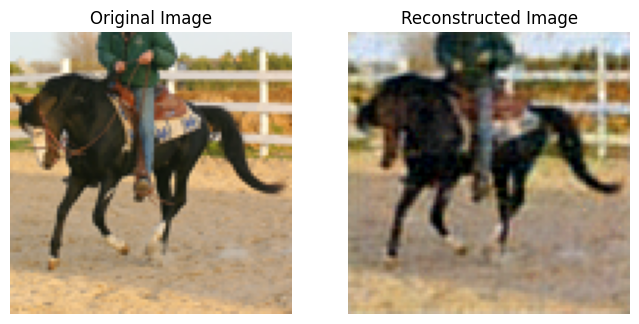

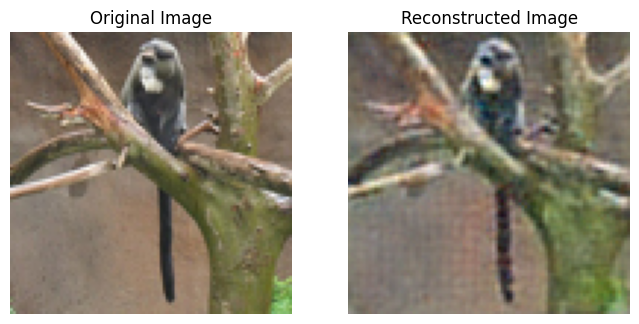

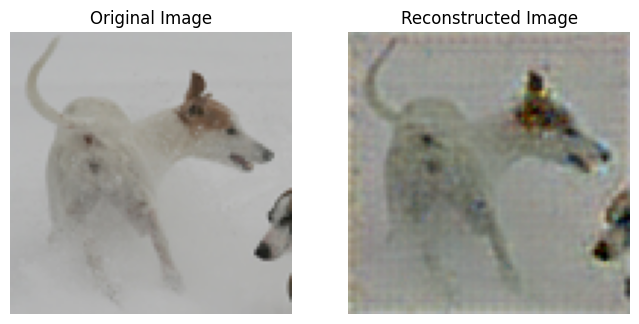

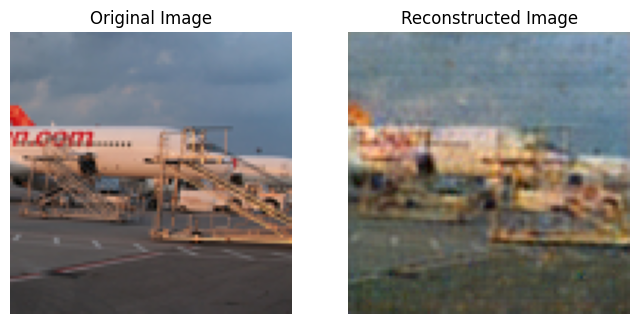

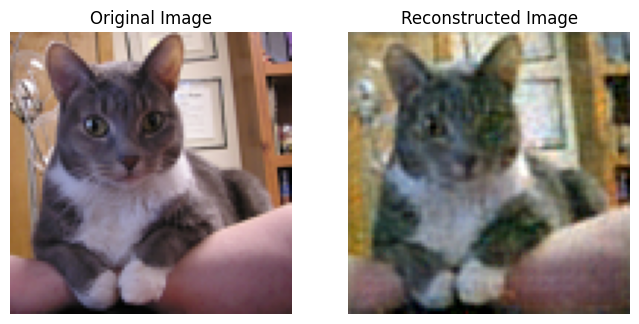

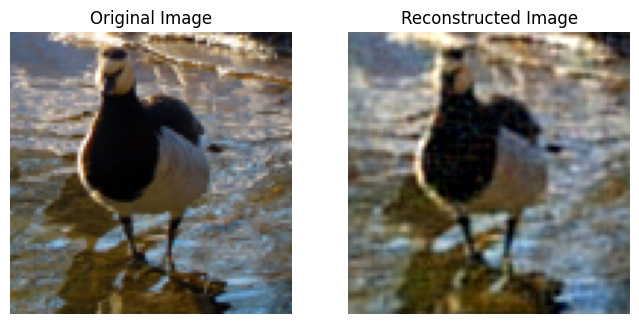

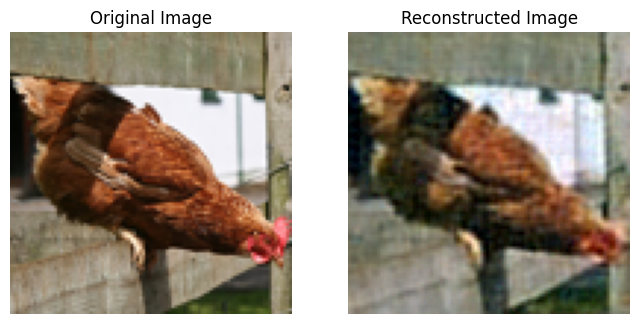

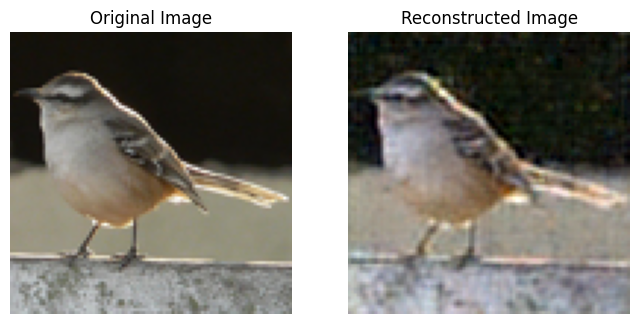

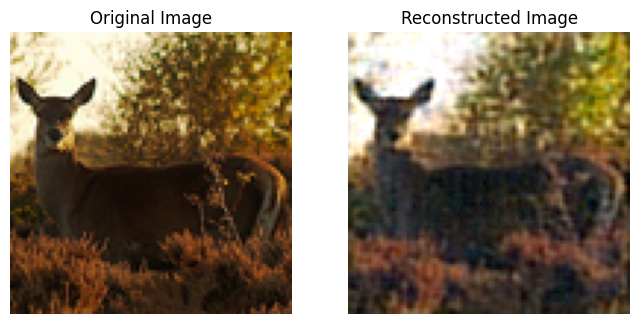

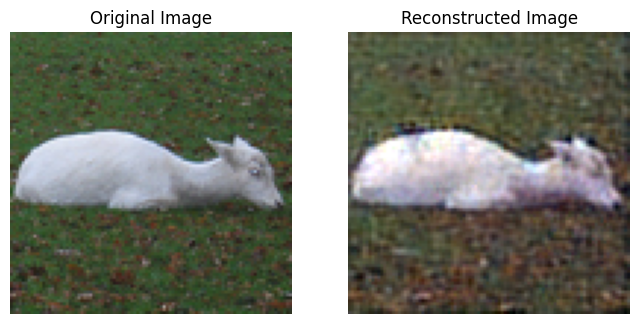

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- STL-10 Test Dataset ---
stl10_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize if you used normalization during training
])

stl10_test_dataset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=stl10_test_transform)
stl10_test_loader = DataLoader(stl10_test_dataset, batch_size=1, shuffle=False)  # Batch size 1 for individual image display

# --- Function to Display Images ---
def imshow(img, title=""):
    img = img / 2 + 0.5     # Unnormalize if needed
    img = img.cpu() # Move the tensor to the CPU
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# --- Inference and Visualization ---
num_images_to_show = 10 # You can change this

for i, (data, _) in enumerate(stl10_test_loader):
    if i >= num_images_to_show:
        break

    data = data.to(device)

    # Inference
    with torch.no_grad():
        reconstructed_data = model(data)

    # Display Images
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    imshow(data.squeeze(0), title="Original Image")

    plt.subplot(1, 2, 2)
    imshow(reconstructed_data.squeeze(0), title="Reconstructed Image")

    plt.show()

In [ ]:
cifar_train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
cifar_train_loader = DataLoader(cifar_train_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified


In [ ]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, channels=[64, 128, 256, 512]):
        super().__init__()
        layers = []
        layers.append(nn.Conv2d(in_channels, channels[0], kernel_size=2, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        for i in range(len(channels) - 1):
            layers.append(nn.Conv2d(channels[i], channels[i+1], kernel_size=2, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(channels[i+1]))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Dropout(0.1))

        layers.append(nn.Conv2d(channels[-1], 1, kernel_size=3, stride=1, padding=0))  # Output 1 channel
        layers.append(nn.Sigmoid()) # Output probability

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x).view(-1, 1) # Reshape to (batch_size, 1)

discriminator = Discriminator()
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout(p=0.1, inplace=False)
    (10): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout(p=0.1, inplace=False)
    (14): Conv2d(512, 1, kernel_size=(3, 3), stride=(1,

In [ ]:
# --- Freeze Layers (Except Decoder Head) ---
for name, param in model.named_parameters():
    if "decoder.final_conv" not in name:  # Only keep decoder.final_conv layers unfrozen
        param.requires_grad = False
    else:
        param.requires_grad = True

# --- Optimizers ---
optimizer_G = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=.01)
optimizer_D = torch.optim.AdamW(discriminator.parameters(), lr=1e-4, weight_decay=.01)

# --- Loss Functions ---
criterion_recon = nn.L1Loss()  # Or L1Loss, or LPIPS
criterion_GAN = nn.BCELoss()

# --- Phase 3 Training Loop ---
num_epochs_phase3 = 20
for epoch in range(num_epochs_phase3):
    for batch_idx, (data, _) in enumerate(cifar_train_loader):
        data = data.to(device)
        batch_size = data.size(0)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()

        # Real Images
        real_labels = torch.ones(batch_size, 1).to(device)
        output_real = discriminator(data)
        loss_D_real = criterion_GAN(output_real, real_labels)

        # Fake Images
        with torch.no_grad():
            fake_data = model(data)  # Generate fake images (no grad through generator)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        output_fake = discriminator(fake_data.detach())  # Detach to avoid backprop through generator
        loss_D_fake = criterion_GAN(output_fake, fake_labels)

        # Total Discriminator Loss
        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # --- Train Generator (Decoder Head) ---
        optimizer_G.zero_grad()
        fake_data = model(data)
        output_fake = discriminator(fake_data)
        loss_G_GAN = criterion_GAN(output_fake, real_labels)  # Try to fool discriminator
        loss_G_recon = criterion_recon(fake_data, data)  # Reconstruction loss
        loss_G = loss_G_GAN + 0.5 * loss_G_recon # Adjust weighting as needed

        loss_G.backward()
        optimizer_G.step()

        if batch_idx % 10 == 0:
            print(f'Phase 3 - Epoch: {epoch+1}/{num_epochs_phase3}, Batch: {batch_idx+1}/{len(cifar_train_loader)}, '
                  f'Loss D: {loss_D.item():.4f}, Loss G (GAN): {loss_G_GAN.item():.4f}, Loss G (Recon): {loss_G_recon.item():.4f}')

Phase 3 - Epoch: 1/20, Batch: 1/98, Loss D: 0.7123, Loss G (GAN): 0.8287, Loss G (Recon): 0.1247
Phase 3 - Epoch: 1/20, Batch: 11/98, Loss D: 0.6087, Loss G (GAN): 0.8786, Loss G (Recon): 0.1195
Phase 3 - Epoch: 1/20, Batch: 21/98, Loss D: 0.5221, Loss G (GAN): 1.0431, Loss G (Recon): 0.1121
Phase 3 - Epoch: 1/20, Batch: 31/98, Loss D: 0.4543, Loss G (GAN): 1.3411, Loss G (Recon): 0.1105
Phase 3 - Epoch: 1/20, Batch: 41/98, Loss D: 0.4051, Loss G (GAN): 1.3869, Loss G (Recon): 0.1041
Phase 3 - Epoch: 1/20, Batch: 51/98, Loss D: 0.3293, Loss G (GAN): 1.1922, Loss G (Recon): 0.1035
Phase 3 - Epoch: 1/20, Batch: 61/98, Loss D: 0.2478, Loss G (GAN): 1.7532, Loss G (Recon): 0.1078
Phase 3 - Epoch: 1/20, Batch: 71/98, Loss D: 0.1704, Loss G (GAN): 2.3064, Loss G (Recon): 0.1094
Phase 3 - Epoch: 1/20, Batch: 81/98, Loss D: 0.1022, Loss G (GAN): 2.7765, Loss G (Recon): 0.1122
Phase 3 - Epoch: 1/20, Batch: 91/98, Loss D: 0.0599, Loss G (GAN): 3.4611, Loss G (Recon): 0.1164
Phase 3 - Epoch: 2/20

Files already downloaded and verified


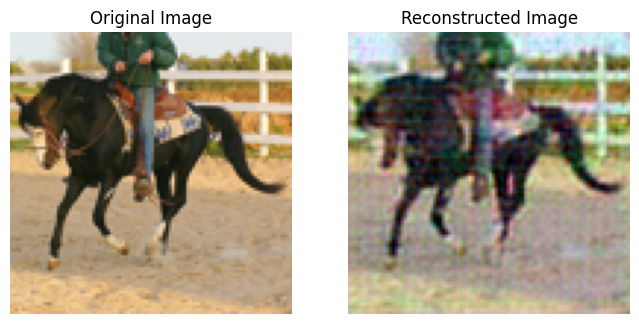

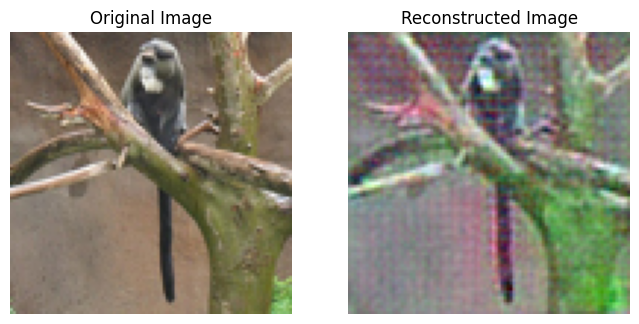

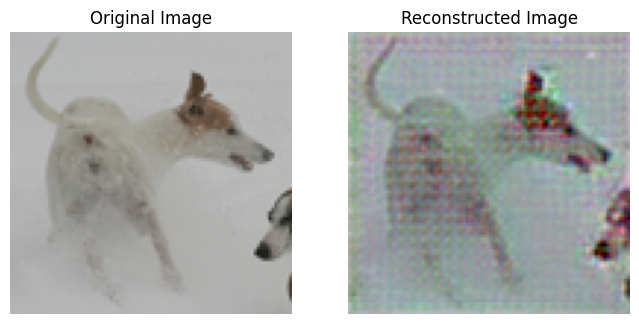

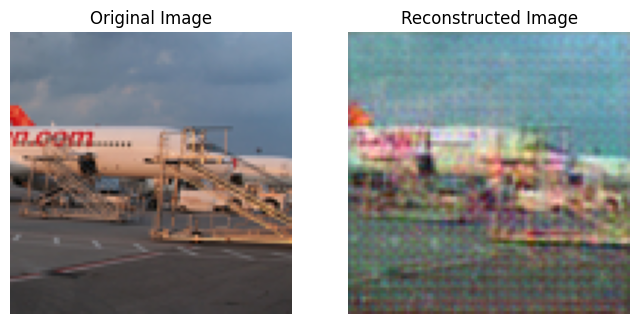

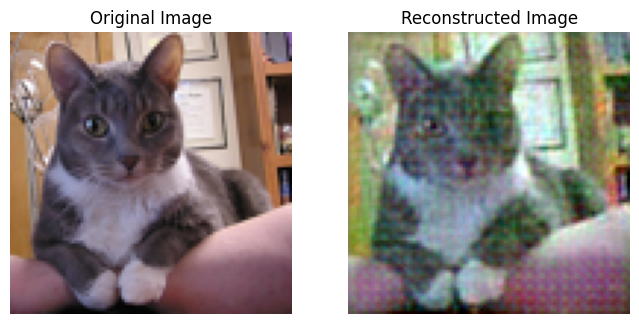

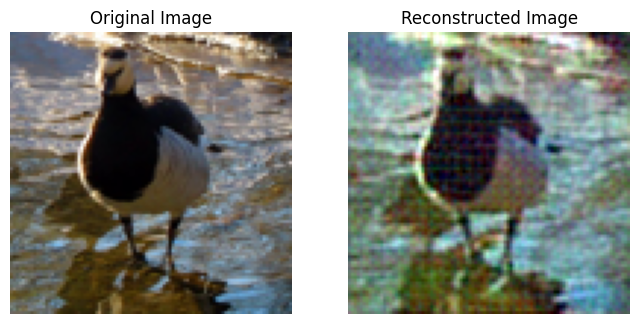

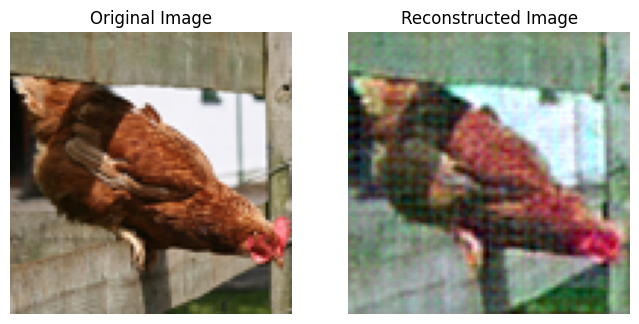

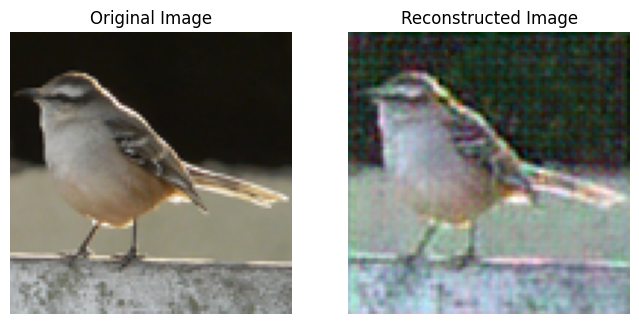

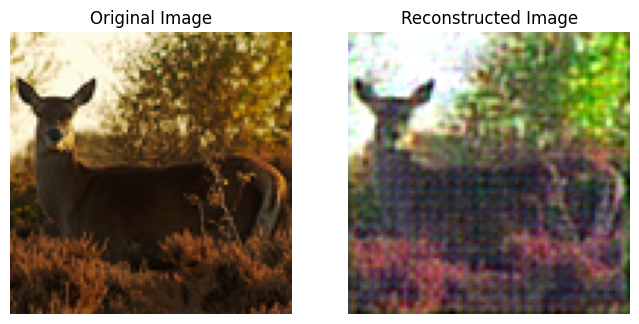

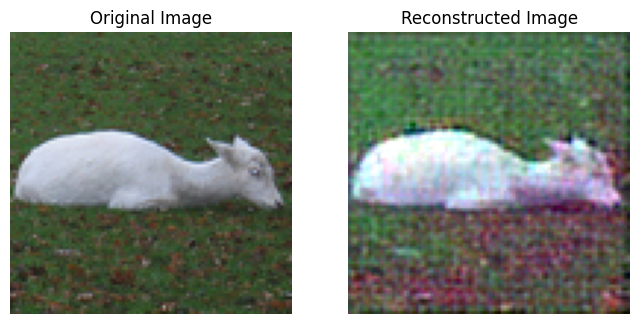

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- STL-10 Test Dataset ---
stl10_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize if you used normalization during training
])

stl10_test_dataset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=stl10_test_transform)
stl10_test_loader = DataLoader(stl10_test_dataset, batch_size=1, shuffle=False)  # Batch size 1 for individual image display

# --- Function to Display Images ---
def imshow(img, title=""):
    img = img / 2 + 0.5     # Unnormalize if needed
    img = img.cpu() # Move the tensor to the CPU
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# --- Inference and Visualization ---
num_images_to_show = 10 # You can change this

for i, (data, _) in enumerate(stl10_test_loader):
    if i >= num_images_to_show:
        break

    data = data.to(device)

    # Inference
    with torch.no_grad():
        reconstructed_data = model(data)

    # Display Images
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    imshow(data.squeeze(0), title="Original Image")

    plt.subplot(1, 2, 2)
    imshow(reconstructed_data.squeeze(0), title="Reconstructed Image")

    plt.show()